In [66]:
# !pip install mplfinance
# !pip install yfinance

In [67]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
from itertools import product

TICKER_1, TICKER_2 = "NVDA", "^GSPC"
START_DATE = "2023-01-01"
END_DATE = "2024-12-31"

ticker_1_df = yf.download(TICKER_1, start=START_DATE, end=END_DATE, auto_adjust=True)
ticker_2_df = yf.download(TICKER_2, start=START_DATE, end=END_DATE, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [68]:
def MACD(df, window_fast, window_slow, window_signal):
    price = df['Close']
    ema_fast = price.ewm(span=window_fast, adjust=False, min_periods=window_fast).mean()
    ema_slow = price.ewm(span=window_slow, adjust=False, min_periods=window_slow).mean()
    macd_line = ema_fast - ema_slow                      # 표준 정의
    signal    = macd_line.ewm(span=window_signal, adjust=False, min_periods=window_signal).mean()
    diff      = macd_line - signal
    out = pd.DataFrame({
        'ema_fast': ema_fast, 'ema_slow': ema_slow,
        'macd': macd_line, 'signal': signal, 'diff': diff,
        'bar_positive': diff.where(diff > 0, 0.0),
        'bar_negative': diff.where(diff < 0, 0.0),
    })
    return out


In [69]:
class CustomTimeSeriesSplit:
    """
    워크-포워드 split
    - n_splits: 분할 개수
    - test_size: 각 폴드의 테스트 길이(없으면 n_samples //(n_splits+1) 로 자동결정)
    - gap: train과 test 사이의 비워두는 구간(정보누설 방지용)
    - max_train_size: 학습창 상한(롤링창처럼 쓰고 싶을 때 지정; None이면 확장형 창)
    """
    def __init__(self, n_splits=5, test_size=None, gap=0, max_train_size=None):
        self.n_splits = int(n_splits)
        self.test_size = None if test_size is None else int(test_size)
        self.gap = int(gap)
        self.max_train_size = None if max_train_size is None else int(max_train_size)

    def split(self, X):
        n_samples = len(X)
        if self.n_splits < 1:
            raise ValueError("n_splits must be >= 1")

        # test_size가 None이면 균등 폴드 크기 사용
        test_size = self.test_size
        if test_size is None:
            test_size = n_samples // (self.n_splits + 1)
            if test_size < 1:
                raise ValueError("Too few samples for given n_splits.")

        for i in range(self.n_splits):
            # 학습 구간 끝(확장형): 매 폴드마다 test_size만큼 전진
            train_end = (i + 1) * test_size
            test_start = train_end + self.gap
            test_end = test_start + test_size

            if test_end > n_samples:
                break  # 남은 데이터가 부족하면 중단

            if self.max_train_size is None:
                train_start = 0  # 확장형(anchored expanding)
            else:
                train_start = max(0, train_end - self.max_train_size)  # 롤링 상한

            train_idx = np.arange(train_start, train_end, dtype=int)
            test_idx = np.arange(test_start, test_end, dtype=int)
            yield train_idx, test_idx

In [70]:
def simulate_strategy(df, macd_line, signal_line):
    """Simulates a simple MACD crossover strategy and returns the cumulative return."""
    # 'position' column: 1 indicates a "buy" or "hold" position, 0 indicates no position.
    # A position is taken when the MACD line is above the signal line.
    df['position'] = np.where(macd_line > signal_line, 1, 0)
    # 'returns' column: Calculate the daily percentage change in closing price.
    df['returns'] = df['Close'].pct_change()
    # 'strategy_returns': Calculate the returns based on our strategy.
    # We use .shift(1) because we make a buy/sell decision based on the previous day's signal.
    df['strategy_returns'] = df['position'].shift(1) * df['returns']
    # Calculate and return the final cumulative product of the strategy returns.
    # This represents the total growth of an initial investment of 1.
    return (1 + df['strategy_returns']).cumprod().iloc[-1]

def create_params_combinations():
    # Define the parameter grid for validation
    param_grid = {
        'window_fast': [10, 12, 15],
        'window_slow': [20, 26, 30],
        'window_signal': [7, 9, 12]
    }
    return list(product(*param_grid.values()))

def grid_search_params(df, param_combinations):
    # Time Series Cross Validation
    tscv = CustomTimeSeriesSplit(n_splits=5, test_size=63, gap=5, max_train_size=None)

    results = []

    # Run the cross-validation loop
    for params in param_combinations:
        fast, slow, signal = params

        # slow is larger than fast
        if slow <= fast:
            continue

        fold_returns = []
        for train_index, test_index in tscv.split(df):
            # Train and Test data spilt
            train_df = df.iloc[train_index]
            test_df = df.iloc[test_index]

            # Calc MACD using train data
            macd_train = MACD(train_df, fast, slow, signal)


            # Calc MACD at Test data (Assume data is coming)
            full_period_df = pd.concat([train_df, test_df])
            macd_test = MACD(full_period_df, fast, slow, signal)

            # Choose test MACD
            test_macd = macd_test['macd'].iloc[len(train_df):]
            test_signal = macd_test['signal'].iloc[len(train_df):]

            # simulation using test data
            fold_return = simulate_strategy(test_df.copy(), test_macd, test_signal)
            fold_returns.append(fold_return)

        # Calc average return
        avg_return = np.mean(fold_returns)
        results.append({
            'params': params,
            'avg_return': avg_return
        })
    return results

In [71]:
def RSI(prices, window=14):
    """RSI (Relative Strength Index) 계산"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def BollingerBands(prices, window=20, num_std=2):
    """볼린저 밴드 계산"""
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, sma, lower_band


def Stochastic(high, low, close, k_window=14, d_window=3):
    """스토캐스틱 오실레이터 계산"""
    lowest_low = low.rolling(window=k_window).min()
    highest_high = high.rolling(window=k_window).max()
    k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    d_percent = k_percent.rolling(window=d_window).mean()
    return k_percent, d_percent

In [72]:
# Golden Cross & Dead Cross 분석 함수
def analyze_golden_dead_cross(df, short_window=20, long_window=60):
    """
    Golden Cross와 Dead Cross 분석
    - Golden Cross: 단기 이동평균이 장기 이동평균을 상향 돌파
    - Dead Cross: 단기 이동평균이 장기 이동평균을 하향 돌파
    """
    # 이동평균 계산
    df["MA_short"] = df["Close"].rolling(window=short_window).mean()
    df["MA_long"] = df["Close"].rolling(window=long_window).mean()

    # 교차 신호 생성
    df["MA_diff"] = df["MA_short"] - df["MA_long"]
    df["MA_diff_prev"] = df["MA_diff"].shift(1)

    # Golden Cross: 이전에는 음수, 현재는 양수
    df["Golden_Cross"] = (df["MA_diff"] > 0) & (df["MA_diff_prev"] <= 0)
    # Dead Cross: 이전에는 양수, 현재는 음수
    df["Dead_Cross"] = (df["MA_diff"] < 0) & (df["MA_diff_prev"] >= 0)

    return df

# 1. NVDA 종목 분석

In [73]:
print(f"\n {TICKER_1} \n", ticker_1_df)
print("Multi colums: \n", ticker_1_df.columns)


 NVDA 
 Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2023-01-03   14.301478   14.981836   14.082685   14.836972  401277000
2023-01-04   14.735070   14.838972   14.227551   14.553243  431324000
2023-01-05   14.251528   14.550245   14.134638   14.477314  389168000
2023-01-06   14.844967   14.995824   14.020746   14.460330  405044000
2023-01-09   15.613240   16.040836   15.126700   15.269565  504231000
...                ...         ...         ...         ...        ...
2024-12-23  139.639572  139.759541  135.090560  136.250311  176053500
2024-12-24  140.189468  141.869095  138.619803  139.969515  105157000
2024-12-26  139.899521  140.819334  137.700003  139.669575  116205600
2024-12-27  136.980164  138.989736  134.680677  138.519837  170582600
2024-12-30  137.460052  140.239446  133.990807  134.800628  167734700

[501 rows 

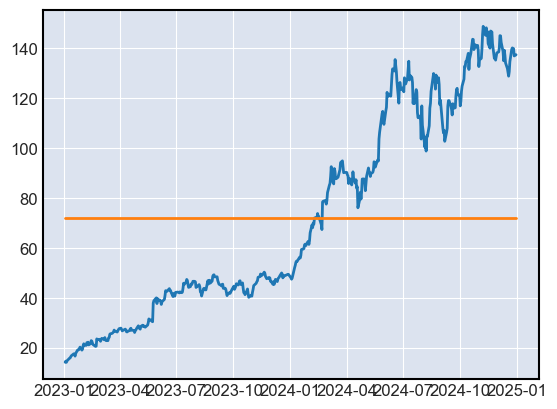

In [74]:
X = ticker_1_df.index
Y = [ticker_1_df["Close"].mean()] * len(X)

plt.plot(X, ticker_1_df["Close"])
plt.plot(X, Y)

In [75]:
ticker_1_df.columns = ticker_1_df.columns.droplevel("Ticker")

TICKER_1_px = ticker_1_df["Close"]

TICKER_1_px

Date
2023-01-03     14.301478
2023-01-04     14.735070
2023-01-05     14.251528
2023-01-06     14.844967
2023-01-09     15.613240
                 ...    
2024-12-23    139.639572
2024-12-24    140.189468
2024-12-26    139.899521
2024-12-27    136.980164
2024-12-30    137.460052
Name: Close, Length: 501, dtype: float64

### 1-1. EMA 그리기

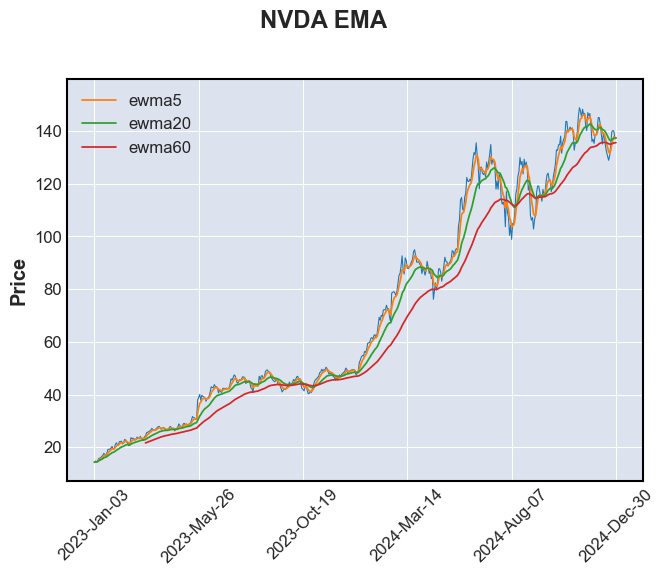

In [76]:
# 5-day, 20-day, 60-day moving average of stock price with exponential weighting
# alpha = 2 / (span +1) for span >= 1
ewma5 = TICKER_1_px.ewm(span=5).mean()  # 5-day ema
ewma20 = TICKER_1_px.ewm(span=20).mean()  # 20-day ema
ewma60 = TICKER_1_px.ewm(span=60, min_periods=50).mean()  # 60-day ema

sma60 = TICKER_1_px.rolling(window=60, min_periods=50).mean()
apds = [
    mpf.make_addplot(ewma5, label="ewma5"),
    mpf.make_addplot(ewma20, label="ewma20"),
    mpf.make_addplot(ewma60, label="ewma60"),
]

mpf.plot(
    ticker_1_df,
    type="line",
    # mav=[5, 20, 60],
    addplot=apds,
    volume=False,
    title=f"{TICKER_1} EMA",
)

### 1-2. MACD 분석

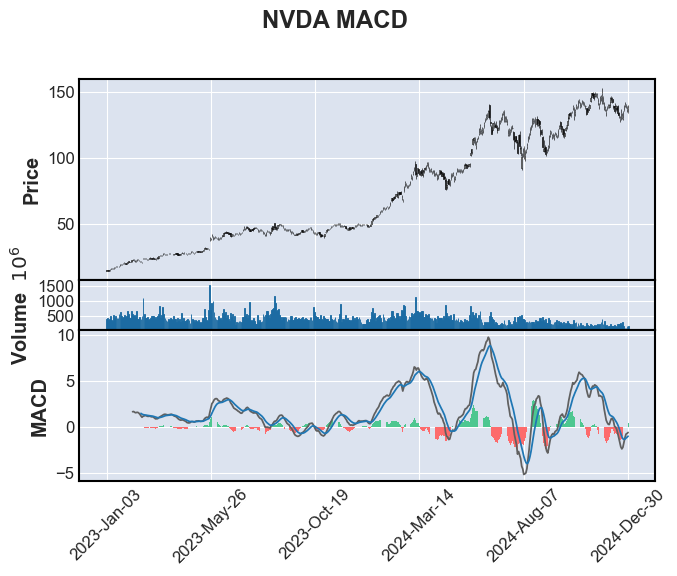

In [77]:
# 표준 파라미터
macd = MACD(ticker_1_df, 12, 26, 9)
macd_plot = [
    mpf.make_addplot(
        (macd["macd"]), color="#606060", panel=2, ylabel="MACD", secondary_y=False
    ),
    mpf.make_addplot((macd["signal"]), color="#1f77b4", panel=2, secondary_y=False),
    mpf.make_addplot((macd["bar_positive"]), type="bar", color="#4dc790", panel=2),
    mpf.make_addplot((macd["bar_negative"]), type="bar", color="#fd6b6c", panel=2),
]

mpf.plot(
    ticker_1_df,
    type="candle",
    volume=True,
    addplot=macd_plot,
    panel_ratios=(4, 1, 3),
    title=f"{TICKER_1} MACD",
)

In [78]:
# Time-series Cross Validation

# Create all parameter combinations from the grid
param_combinations = create_params_combinations()

results = grid_search_params(ticker_1_df, param_combinations)

# Result Analysis
results_df = pd.DataFrame(results).sort_values(by='avg_return', ascending=False)

print("--- 최적 MACD 파라미터 검증 결과 (평균 누적수익률 기준) ---")
print(results_df.head())

print(f"\n표준 파라미터 (12, 26, 9)의 결과:")
print(results_df[results_df['params'] == (12, 26, 9)])

--- 최적 MACD 파라미터 검증 결과 (평균 누적수익률 기준) ---
          params  avg_return
9    (12, 20, 7)    1.241552
1    (10, 20, 9)    1.237833
2   (10, 20, 12)    1.229969
10   (12, 20, 9)    1.229263
15   (12, 30, 7)    1.228925

표준 파라미터 (12, 26, 9)의 결과:
         params  avg_return
13  (12, 26, 9)    1.222878


### 1-3. Golden Cross & Dead Cross 분석

=== MSFT Golden Cross & Dead Cross 분석 ===
Golden Cross 발생 횟수: 3
Dead Cross 발생 횟수: 4

Golden Cross 발생 날짜:
  2023-11-17: 가격 49.27
  2024-05-16: 가격 94.32
  2024-10-04: 가격 124.88

Dead Cross 발생 날짜:
  2023-09-28: 가격 43.06
  2024-05-13: 가격 90.36
  2024-08-07: 가격 98.87
  2024-12-20: 가격 134.67


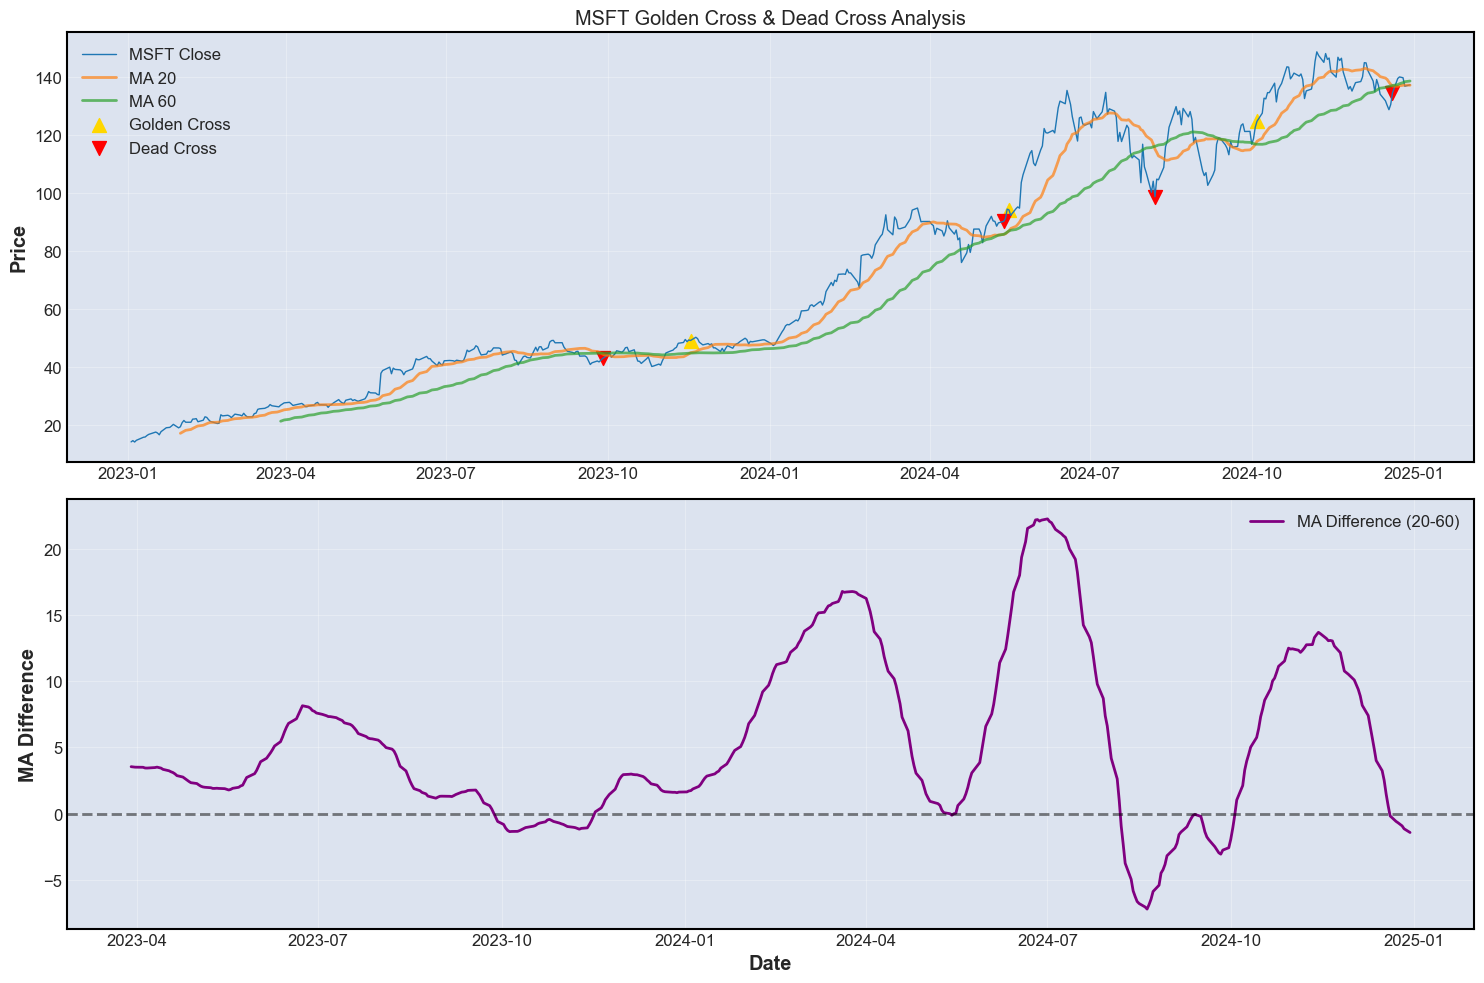

In [79]:
# MSFT Golden Cross & Dead Cross 분석
msft_analysis = analyze_golden_dead_cross(ticker_1_df, 20, 60)

# Golden Cross와 Dead Cross 발생 시점 찾기
msft_golden_cross_dates = msft_analysis[msft_analysis["Golden_Cross"]].index
msft_dead_cross_dates = msft_analysis[msft_analysis["Dead_Cross"]].index

print("=== MSFT Golden Cross & Dead Cross 분석 ===")
print(f"Golden Cross 발생 횟수: {len(msft_golden_cross_dates)}")
print(f"Dead Cross 발생 횟수: {len(msft_dead_cross_dates)}")

if len(msft_golden_cross_dates) > 0:
    print(f"\nGolden Cross 발생 날짜:")
    for date in msft_golden_cross_dates:
        print(
            f"  {date.strftime('%Y-%m-%d')}: 가격 {msft_analysis.loc[date, 'Close']:.2f}"
        )

if len(msft_dead_cross_dates) > 0:
    print(f"\nDead Cross 발생 날짜:")
    for date in msft_dead_cross_dates:
        print(
            f"  {date.strftime('%Y-%m-%d')}: 가격 {msft_analysis.loc[date, 'Close']:.2f}"
        )

# 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 첫 번째 차트: 가격과 이동평균
ax1.plot(msft_analysis.index, msft_analysis["Close"], label="MSFT Close", linewidth=1)
ax1.plot(msft_analysis.index, msft_analysis["MA_short"], label=f"MA {20}", alpha=0.7)
ax1.plot(msft_analysis.index, msft_analysis["MA_long"], label=f"MA {60}", alpha=0.7)

# Golden Cross 표시
for date in msft_golden_cross_dates:
    ax1.scatter(
        date,
        msft_analysis.loc[date, "Close"],
        color="gold",
        s=100,
        marker="^",
        label="Golden Cross" if date == msft_golden_cross_dates[0] else "",
    )

# Dead Cross 표시
for date in msft_dead_cross_dates:
    ax1.scatter(
        date,
        msft_analysis.loc[date, "Close"],
        color="red",
        s=100,
        marker="v",
        label="Dead Cross" if date == msft_dead_cross_dates[0] else "",
    )

ax1.set_title("MSFT Golden Cross & Dead Cross Analysis")
ax1.set_ylabel("Price")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 두 번째 차트: 이동평균 차이
ax2.plot(
    msft_analysis.index,
    msft_analysis["MA_diff"],
    label="MA Difference (20-60)",
    color="purple",
)
ax2.axhline(y=0, color="black", linestyle="--", alpha=0.5)
ax2.set_ylabel("MA Difference")
ax2.set_xlabel("Date")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1-4. RSI, BollingerBands, Stochastic Oscillator

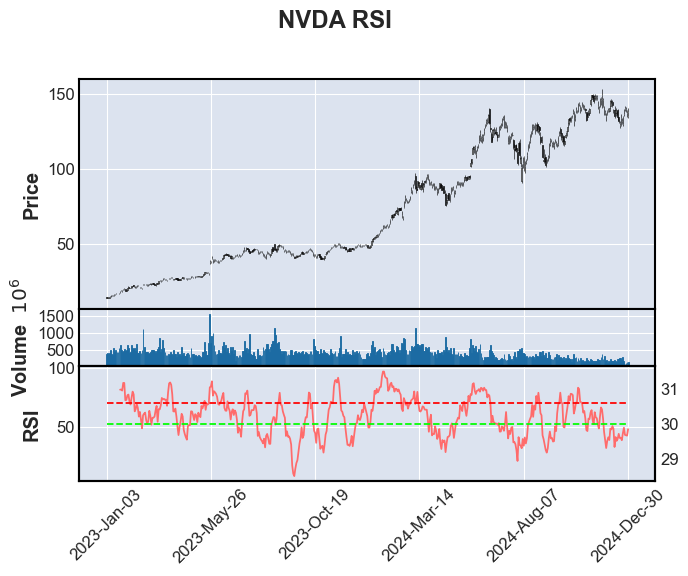

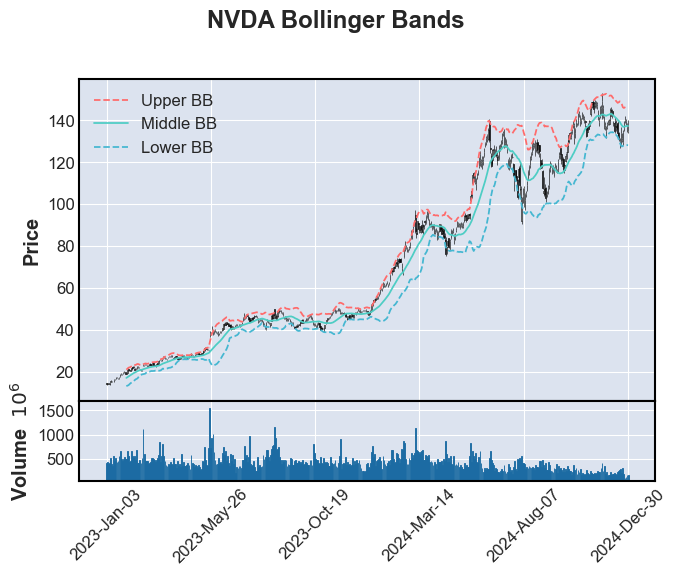

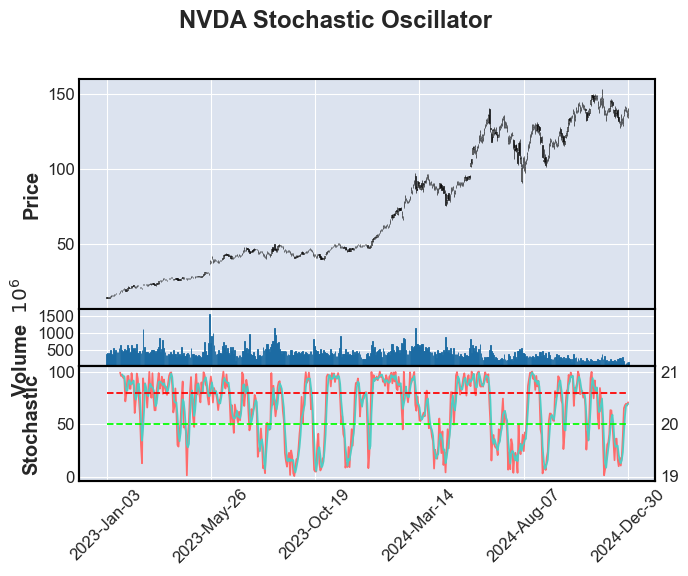

In [80]:
# RSI 분석
rsi = RSI(TICKER_1_px, window=14)
rsi_plot = [
    mpf.make_addplot(rsi, color="#ff6b6b", panel=2, ylabel="RSI", secondary_y=False),
    mpf.make_addplot([70] * len(rsi), color="#ff0000", linestyle="--", panel=2),
    mpf.make_addplot([30] * len(rsi), color="#00ff00", linestyle="--", panel=2),
]

mpf.plot(
    ticker_1_df,
    type="candle",
    volume=True,
    addplot=rsi_plot,
    panel_ratios=(4, 1, 2),
    title=f"{TICKER_1} RSI",
)

# 볼린저 밴드 분석
upper_band, middle_band, lower_band = BollingerBands(TICKER_1_px, window=20, num_std=2)
bb_plot = [
    mpf.make_addplot(upper_band, color="#ff6b6b", linestyle="--", label="Upper BB"),
    mpf.make_addplot(middle_band, color="#4ecdc4", label="Middle BB"),
    mpf.make_addplot(lower_band, color="#45b7d1", linestyle="--", label="Lower BB"),
]

mpf.plot(
    ticker_1_df,
    type="candle",
    volume=True,
    addplot=bb_plot,
    panel_ratios=(4, 1),
    title=f"{TICKER_1} Bollinger Bands",
)

# 스토캐스틱 오실레이터 분석
k_percent, d_percent = Stochastic(
    ticker_1_df["High"], ticker_1_df["Low"], ticker_1_df["Close"]
)
stoch_plot = [
    mpf.make_addplot(
        k_percent, color="#ff6b6b", panel=2, ylabel="Stochastic", secondary_y=False
    ),
    mpf.make_addplot(d_percent, color="#4ecdc4", panel=2, secondary_y=False),
    mpf.make_addplot([80] * len(k_percent), color="#ff0000", linestyle="--", panel=2),
    mpf.make_addplot([20] * len(k_percent), color="#00ff00", linestyle="--", panel=2),
]

mpf.plot(
    ticker_1_df,
    type="candle",
    volume=True,
    addplot=stoch_plot,
    panel_ratios=(4, 1, 2),
    title=f"{TICKER_1} Stochastic Oscillator",
)

In [81]:
# NVDA 기술적 지표 분석 결과
print(f"\n=== {TICKER_1} 기술적 지표 분석 결과 ===")

# RSI 분석
rsi_nvda = RSI(TICKER_1_px, window=14)
print(f"\nRSI 분석:")
print(f"현재 RSI: {rsi_nvda.iloc[-1]:.2f}")
print(f"RSI 평균: {rsi_nvda.mean():.2f}")
print(f"RSI 최대값: {rsi_nvda.max():.2f}")
print(f"RSI 최소값: {rsi_nvda.min():.2f}")
print(f"과매수 구간(>70) 비율: {(rsi_nvda > 70).sum() / len(rsi_nvda) * 100:.1f}%")
print(f"과매도 구간(<30) 비율: {(rsi_nvda < 30).sum() / len(rsi_nvda) * 100:.1f}%")

# 볼린저 밴드 분석
upper_bb, middle_bb, lower_bb = BollingerBands(TICKER_1_px, window=20, num_std=2)
bb_position = (TICKER_1_px - lower_bb) / (upper_bb - lower_bb)
print(f"\n볼린저 밴드 분석:")
print(f"현재 가격 위치: {bb_position.iloc[-1]:.2f} (0=하단, 1=상단)")
print(f"밴드 폭: {((upper_bb - lower_bb) / middle_bb).mean():.2f}")
print(f"상단 밴드 터치 횟수: {(TICKER_1_px >= upper_bb).sum()}")
print(f"하단 밴드 터치 횟수: {(TICKER_1_px <= lower_bb).sum()}")

# 스토캐스틱 오실레이터 분석
k_percent, d_percent = Stochastic(
    ticker_1_df["High"], ticker_1_df["Low"], ticker_1_df["Close"]
)
print(f"\n스토캐스틱 오실레이터 분석:")
print(f"현재 %K: {k_percent.iloc[-1]:.2f}")
print(f"현재 %D: {d_percent.iloc[-1]:.2f}")
print(f"%K 평균: {k_percent.mean():.2f}")
print(f"%D 평균: {d_percent.mean():.2f}")
print(f"과매수 구간(>80) 비율: {(k_percent > 80).sum() / len(k_percent) * 100:.1f}%")
print(f"과매도 구간(<20) 비율: {(k_percent < 20).sum() / len(k_percent) * 100:.1f}%")


=== NVDA 기술적 지표 분석 결과 ===

RSI 분석:
현재 RSI: 48.02
RSI 평균: 59.31
RSI 최대값: 96.99
RSI 최소값: 8.19
과매수 구간(>70) 비율: 26.1%
과매도 구간(<30) 비율: 2.2%

볼린저 밴드 분석:
현재 가격 위치: 0.51 (0=하단, 1=상단)
밴드 폭: 0.22
상단 밴드 터치 횟수: 34
하단 밴드 터치 횟수: 9

스토캐스틱 오실레이터 분석:
현재 %K: 70.68
현재 %D: 69.18
%K 평균: 64.37
%D 평균: 64.29
과매수 구간(>80) 비율: 39.3%
과매도 구간(<20) 비율: 10.8%


# 2. S&P 500(SPY) 분석

In [82]:
print(f"\n {TICKER_2} \n", ticker_2_df)
print("Multi colums: \n", ticker_2_df.columns)


 ^GSPC 
 Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2023-01-03  3824.139893  3878.459961  3794.330078  3853.290039  3959140000
2023-01-04  3852.969971  3873.159912  3815.770020  3840.360107  4414080000
2023-01-05  3808.100098  3839.739990  3802.419922  3839.739990  3893450000
2023-01-06  3895.080078  3906.189941  3809.560059  3823.370117  3923560000
2023-01-09  3892.090088  3950.570068  3890.419922  3910.820068  4311770000
...                 ...          ...          ...          ...         ...
2024-12-23  5974.069824  5978.250000  5902.569824  5940.250000  3593280000
2024-12-24  6040.040039  6040.100098  5981.439941  5984.629883  1757720000
2024-12-26  6037.589844  6049.750000  6007.370117  6024.970215  2904530000
2024-12-27  5970.839844  6006.169922  5932.950195  6006.169922  3159610000
2024-12-30  590

In [83]:
ticker_2_df.columns = ticker_2_df.columns.droplevel("Ticker")

TICKER_2_px = ticker_2_df["Close"]

### 2-1. EMA 그리기

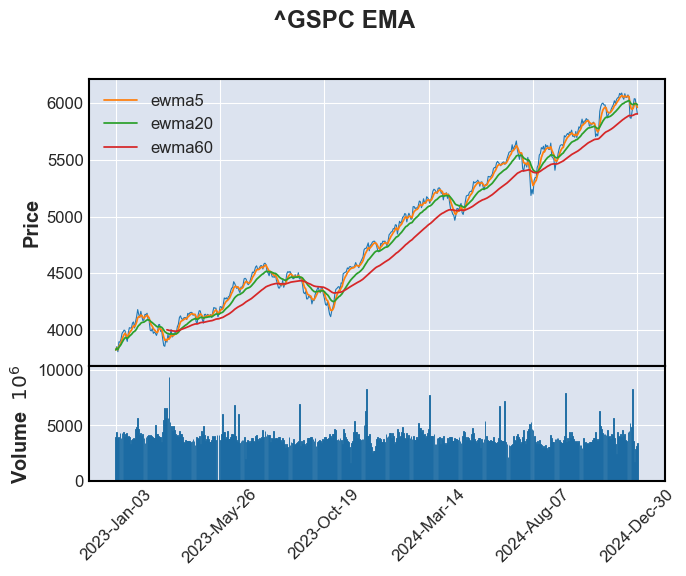

In [84]:
# 5-day, 20-day, 60-day moving average of SPY stock price with exponential weighting

ewma5 = TICKER_2_px.ewm(span=5).mean()  # 5-day ema
ewma20 = TICKER_2_px.ewm(span=20).mean()  # 20-day ema
ewma60 = TICKER_2_px.ewm(span=60, min_periods=50).mean()  # 60-day ema

sma60 = TICKER_2_px.rolling(window=60, min_periods=50).mean()

apds = [
    mpf.make_addplot(ewma5, label="ewma5"),
    mpf.make_addplot(ewma20, label="ewma20"),
    mpf.make_addplot(ewma60, label="ewma60"),
]

mpf.plot(
    ticker_2_df,
    type="line",
    # mav=[5, 20, 60],
    addplot=apds,
    volume=True,
    title=f"{TICKER_2} EMA",
)

### 2-2. MACD 분석

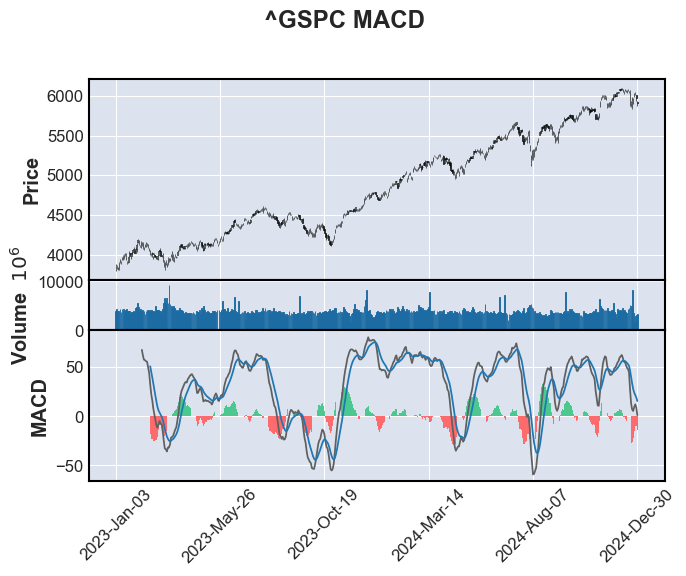

In [85]:
# 표준 파라미터
macd = MACD(ticker_2_df, 12, 26, 9)
macd_plot = [
    mpf.make_addplot(
        (macd["macd"]), color="#606060", panel=2, ylabel="MACD", secondary_y=False
    ),
    mpf.make_addplot((macd["signal"]), color="#1f77b4", panel=2, secondary_y=False),
    mpf.make_addplot((macd["bar_positive"]), type="bar", color="#4dc790", panel=2),
    mpf.make_addplot((macd["bar_negative"]), type="bar", color="#fd6b6c", panel=2),
]

mpf.plot(
    ticker_2_df,
    type="candle",
    volume=True,
    addplot=macd_plot,
    panel_ratios=(4, 1, 3),
    title=f"{TICKER_2} MACD",
)

In [86]:
# Time-series Cross Validation

# Create all parameter combinations from the grid
param_combinations = create_params_combinations()

results = grid_search_params(ticker_2_df, param_combinations)

# Result Analysis
results_df = pd.DataFrame(results).sort_values(by='avg_return', ascending=False)

print("--- 최적 MACD 파라미터 검증 결과 (평균 누적수익률 기준) ---")
print(results_df.head())

print(f"\n표준 파라미터 (12, 26, 9)의 결과:")
print(results_df[results_df['params'] == (12, 26, 9)])

--- 최적 MACD 파라미터 검증 결과 (평균 누적수익률 기준) ---
          params  avg_return
26  (15, 30, 12)    1.027614
0    (10, 20, 7)    1.026425
9    (12, 20, 7)    1.019766
1    (10, 20, 9)    1.019137
23  (15, 26, 12)    1.018745

표준 파라미터 (12, 26, 9)의 결과:
         params  avg_return
13  (12, 26, 9)    1.012486


### 2-3. Golden Cross & Dead Cross 분석

=== SPY Golden Cross & Dead Cross 분석 ===
Golden Cross 발생 횟수: 4
Dead Cross 발생 횟수: 3

Golden Cross 발생 날짜:
  2023-04-13: 가격 4146.22
  2023-11-22: 가격 4556.62
  2024-05-17: 가격 5303.27
  2024-09-03: 가격 5528.93

Dead Cross 발생 날짜:
  2023-08-31: 가격 4507.66
  2024-04-30: 가격 5035.69
  2024-08-13: 가격 5434.43


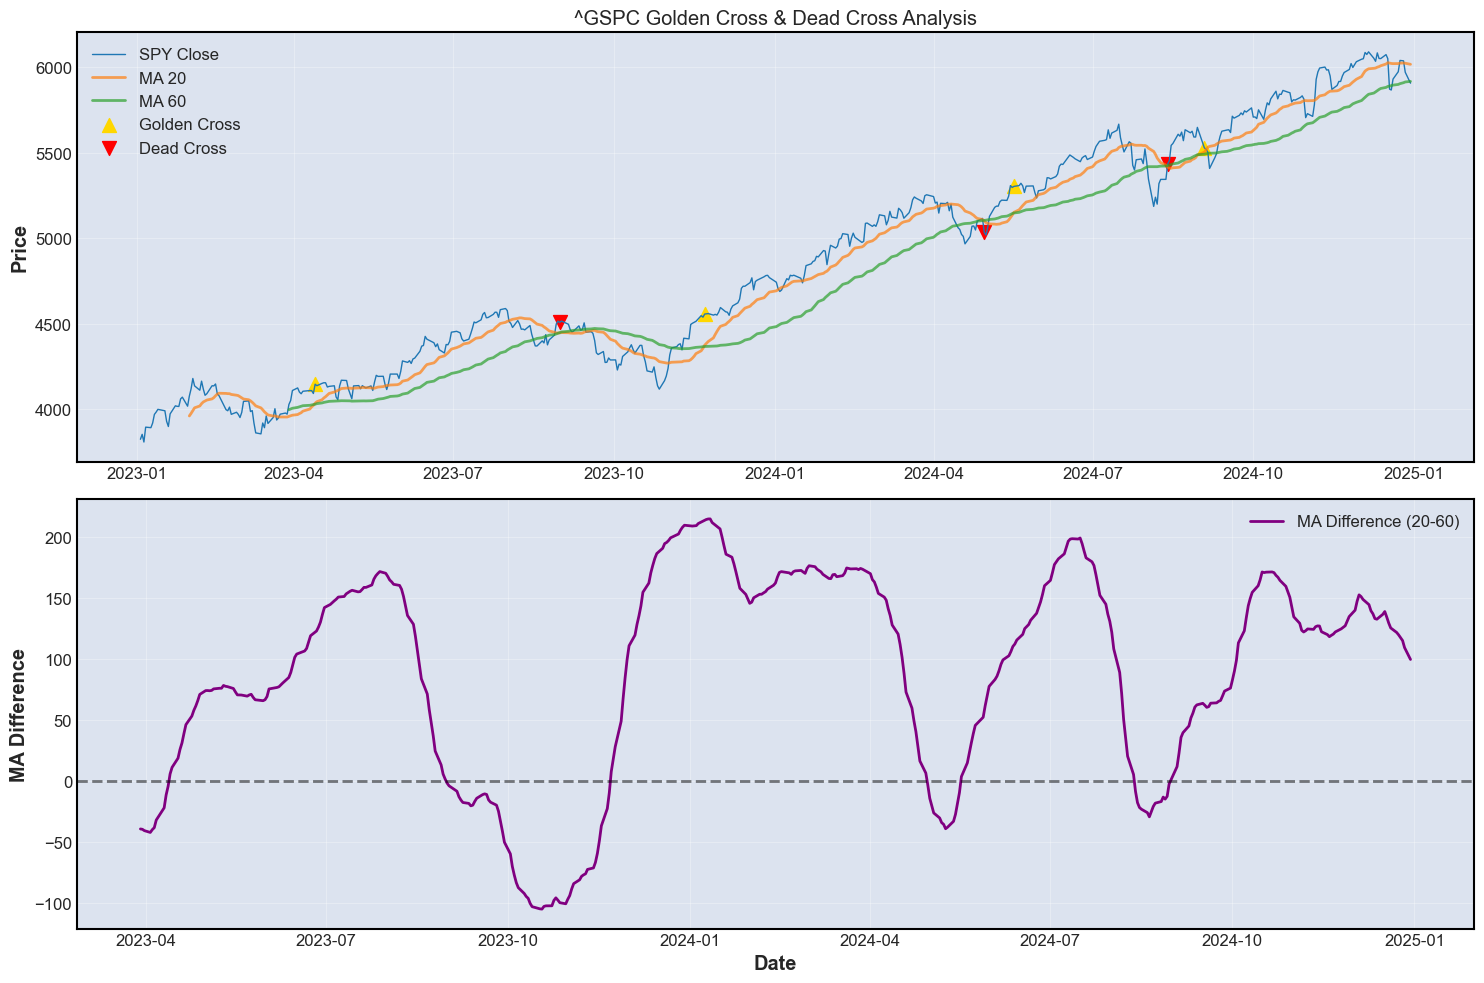

In [87]:
# SPY Golden Cross & Dead Cross 분석
spy_analysis = analyze_golden_dead_cross(ticker_2_df, 20, 60)

# Golden Cross와 Dead Cross 발생 시점 찾기
golden_cross_dates = spy_analysis[spy_analysis['Golden_Cross']].index
dead_cross_dates = spy_analysis[spy_analysis['Dead_Cross']].index

print("=== SPY Golden Cross & Dead Cross 분석 ===")
print(f"Golden Cross 발생 횟수: {len(golden_cross_dates)}")
print(f"Dead Cross 발생 횟수: {len(dead_cross_dates)}")

if len(golden_cross_dates) > 0:
    print(f"\nGolden Cross 발생 날짜:")
    for date in golden_cross_dates:
        print(f"  {date.strftime('%Y-%m-%d')}: 가격 {spy_analysis.loc[date, 'Close']:.2f}")

if len(dead_cross_dates) > 0:
    print(f"\nDead Cross 발생 날짜:")
    for date in dead_cross_dates:
        print(f"  {date.strftime('%Y-%m-%d')}: 가격 {spy_analysis.loc[date, 'Close']:.2f}")

# 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 첫 번째 차트: 가격과 이동평균
ax1.plot(spy_analysis.index, spy_analysis['Close'], label='SPY Close', linewidth=1)
ax1.plot(spy_analysis.index, spy_analysis['MA_short'], label=f'MA {20}', alpha=0.7)
ax1.plot(spy_analysis.index, spy_analysis['MA_long'], label=f'MA {60}', alpha=0.7)

# Golden Cross 표시
for date in golden_cross_dates:
    ax1.scatter(date, spy_analysis.loc[date, 'Close'], color='gold', s=100, marker='^', 
                label='Golden Cross' if date == golden_cross_dates[0] else "")

# Dead Cross 표시
for date in dead_cross_dates:
    ax1.scatter(date, spy_analysis.loc[date, 'Close'], color='red', s=100, marker='v',
                label='Dead Cross' if date == dead_cross_dates[0] else "")

ax1.set_title(f'{TICKER_2} Golden Cross & Dead Cross Analysis')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 두 번째 차트: 이동평균 차이
ax2.plot(spy_analysis.index, spy_analysis['MA_diff'], label='MA Difference (20-60)', color='purple')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_ylabel('MA Difference')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2-4. RSI, BollingerBands, Stochastic Oscillator

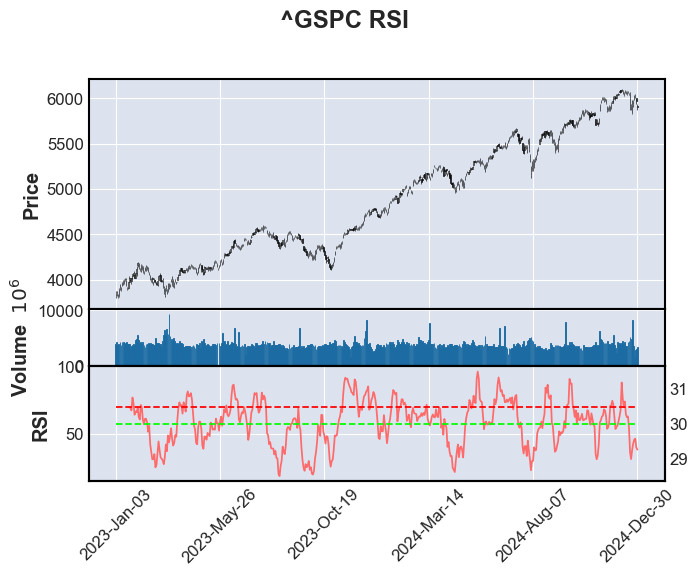

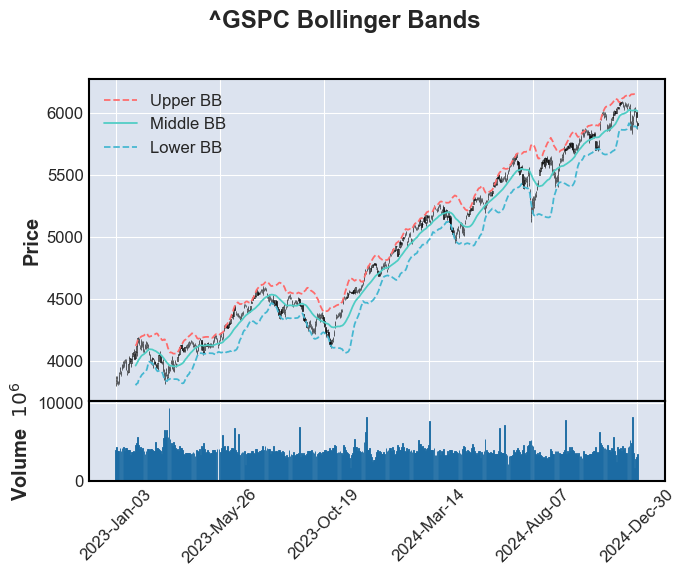

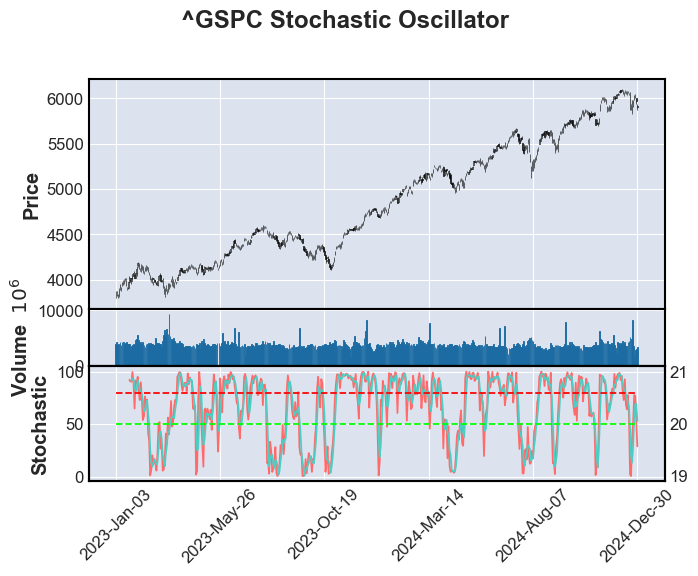

In [88]:
# RSI 분석
rsi = RSI(TICKER_2_px, window=14)
rsi_plot = [
    mpf.make_addplot(rsi, color="#ff6b6b", panel=2, ylabel="RSI", secondary_y=False),
    mpf.make_addplot([70] * len(rsi), color="#ff0000", linestyle="--", panel=2),
    mpf.make_addplot([30] * len(rsi), color="#00ff00", linestyle="--", panel=2),
]

mpf.plot(
    ticker_2_df,
    type="candle",
    volume=True,
    addplot=rsi_plot,
    panel_ratios=(4, 1, 2),
    title=f"{TICKER_2} RSI",
)

# 볼린저 밴드 분석
upper_band, middle_band, lower_band = BollingerBands(TICKER_2_px, window=20, num_std=2)
bb_plot = [
    mpf.make_addplot(upper_band, color="#ff6b6b", linestyle="--", label="Upper BB"),
    mpf.make_addplot(middle_band, color="#4ecdc4", label="Middle BB"),
    mpf.make_addplot(lower_band, color="#45b7d1", linestyle="--", label="Lower BB"),
]

mpf.plot(
    ticker_2_df,
    type="candle",
    volume=True,
    addplot=bb_plot,
    panel_ratios=(4, 1),
    title=f"{TICKER_2} Bollinger Bands",
)

# 스토캐스틱 오실레이터 분석
k_percent, d_percent = Stochastic(
    ticker_2_df["High"], ticker_2_df["Low"], ticker_2_df["Close"]
)
stoch_plot = [
    mpf.make_addplot(
        k_percent, color="#ff6b6b", panel=2, ylabel="Stochastic", secondary_y=False
    ),
    mpf.make_addplot(d_percent, color="#4ecdc4", panel=2, secondary_y=False),
    mpf.make_addplot([80] * len(k_percent), color="#ff0000", linestyle="--", panel=2),
    mpf.make_addplot([20] * len(k_percent), color="#00ff00", linestyle="--", panel=2),
]

mpf.plot(
    ticker_2_df,
    type="candle",
    volume=True,
    addplot=stoch_plot,
    panel_ratios=(4, 1, 2),
    title=f"{TICKER_2} Stochastic Oscillator",
)

In [89]:
# S&P 500 기술적 지표 분석 결과
print(f"\n=== {TICKER_2} 기술적 지표 분석 결과 ===")

# RSI 분석
rsi_spy = RSI(TICKER_2_px, window=14)
print(f"\nRSI 분석:")
print(f"현재 RSI: {rsi_spy.iloc[-1]:.2f}")
print(f"RSI 평균: {rsi_spy.mean():.2f}")
print(f"RSI 최대값: {rsi_spy.max():.2f}")
print(f"RSI 최소값: {rsi_spy.min():.2f}")
print(f"과매수 구간(>70) 비율: {(rsi_spy > 70).sum() / len(rsi_spy) * 100:.1f}%")
print(f"과매도 구간(<30) 비율: {(rsi_spy < 30).sum() / len(rsi_spy) * 100:.1f}%")

# 볼린저 밴드 분석
upper_bb, middle_bb, lower_bb = BollingerBands(TICKER_2_px, window=20, num_std=2)
bb_position = (TICKER_2_px - lower_bb) / (upper_bb - lower_bb)
print(f"\n볼린저 밴드 분석:")
print(f"현재 가격 위치: {bb_position.iloc[-1]:.2f} (0=하단, 1=상단)")
print(f"밴드 폭: {((upper_bb - lower_bb) / middle_bb).mean():.2f}")
print(f"상단 밴드 터치 횟수: {(TICKER_2_px >= upper_bb).sum()}")
print(f"하단 밴드 터치 횟수: {(TICKER_2_px <= lower_bb).sum()}")

# 스토캐스틱 오실레이터 분석
k_percent, d_percent = Stochastic(
    ticker_2_df["High"], ticker_2_df["Low"], ticker_2_df["Close"]
)
print(f"\n스토캐스틱 오실레이터 분석:")
print(f"현재 %K: {k_percent.iloc[-1]:.2f}")
print(f"현재 %D: {d_percent.iloc[-1]:.2f}")
print(f"%K 평균: {k_percent.mean():.2f}")
print(f"%D 평균: {d_percent.mean():.2f}")
print(f"과매수 구간(>80) 비율: {(k_percent > 80).sum() / len(k_percent) * 100:.1f}%")
print(f"과매도 구간(<20) 비율: {(k_percent < 20).sum() / len(k_percent) * 100:.1f}%")


=== ^GSPC 기술적 지표 분석 결과 ===

RSI 분석:
현재 RSI: 38.54
RSI 평균: 58.79
RSI 최대값: 96.23
RSI 최소값: 19.00
과매수 구간(>70) 비율: 25.0%
과매도 구간(<30) 비율: 4.2%

볼린저 밴드 분석:
현재 가격 위치: 0.11 (0=하단, 1=상단)
밴드 폭: 0.06
상단 밴드 터치 횟수: 29
하단 밴드 터치 횟수: 19

스토캐스틱 오실레이터 분석:
현재 %K: 28.68
현재 %D: 52.87
%K 평균: 66.80
%D 평균: 66.82
과매수 구간(>80) 비율: 45.9%
과매도 구간(<20) 비율: 12.8%
